In [1]:
from jaxgym.run import run_to_end, calculate_derivatives
import jaxgym.components as comp
from jaxgym.ray import Ray

import jax
import jax.numpy as jnp

from scipy.constants import h as h_planck, e, m_e, c
import sympy as sp
import os

import matplotlib.pyplot as plt

import optax
from optax import apply_updates
from tqdm import trange
import equinox as eqx

from jaxgym.taylor import poly_dict, order_indices, poly_dict_to_sympy_expr

jax.config.update("jax_platform_name", "cpu")
jax.config.update("jax_enable_x64", True)
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"


%matplotlib widget

/home/dl277493/JaxTemGym/src/jaxgym/ode.py:6: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import trange, tqdm


In [2]:
@eqx.filter_jit
def run_to_end_matrix_wrapper(ray_matrix):
    ray = Ray(
        x=ray_matrix[0],
        y=ray_matrix[1],
        dx=ray_matrix[2],
        dy=ray_matrix[3],
        z=jnp.array(PointSource.z, float),
        pathlength=0.0,
        _one=1.0,
    )

    ray = run_to_end(ray, model)

    ray_matrix_out = jnp.array([ray.x, ray.y, ray.dx, ray.dy]).T
    return ray_matrix_out, ray.pathlength


run_batch = jax.jit(jax.vmap(run_to_end_matrix_wrapper))


@eqx.filter_jit()
def loss(tilts, positions, det_coords):
    tilts_x, tilts_y = tilts[:, 0], tilts[:, 1]
    positions_x, positions_y = positions[:, 0], positions[:, 1]

    ray_matrix = jnp.array([positions_x, positions_y, tilts_x, tilts_y]).T
    ray_matrix_out, _ = run_batch(ray_matrix)

    det_rays_x, det_rays_y, _, _ = ray_matrix_out.T
    rays_at_end = jnp.array([det_rays_x, det_rays_y]).T

    error = jnp.mean(jnp.sum((rays_at_end - det_coords) ** 2, axis=1))
    return error


@eqx.filter_jit
def lbfgs_step(tilts, opt_state, det_coords):
    # compute current loss and grads
    loss_val, grads = jax.value_and_grad(loss, argnums=0)(
        tilts, cur_positions, det_coords
    )
    updates, opt_state = lbfgs_solver.update(
        grads,
        opt_state,
        params=tilts,
        value=loss_val,
        grad=grads,
        value_fn=lambda t: loss(t, cur_positions, det_coords),
    )
    tilts = apply_updates(tilts, updates)
    return tilts, opt_state, loss_val


@eqx.filter_jit
def adam_step(tilts, opt_state, det_coords):
    # compute current loss and grads
    loss_val = loss(tilts, cur_positions, det_coords)
    grads = jax.jacfwd(loss, argnums=0)(tilts, cur_positions, det_coords)
    # update with adamw
    updates, opt_state = adam_solver.update(grads, opt_state, params=tilts)
    tilts = apply_updates(tilts, updates)

    return tilts, opt_state, loss_val

In [3]:
X, Y, Z = sp.symbols("X Y Z")

# Use scipy's constants
e = e  # -1.60217662e-19 #unit C
m = m_e  # 9.10938356e-31 #unit kg
c_l = c  # 2.99792458e8 #unit m/s
eps = abs(e) / (
    2 * m * c_l**2
)  # eps as defined in Hawkes, different from the permittivity of free space.

um = 1e6

# Set z start and end points for electron
z_start = -0.1 * um
z_end = 0.06 * um

# Set initial accelerating voltage.
phi_0 = 80e3

# non-relativistic
wavelength = h_planck / (2 * abs(e) * m * phi_0) ** (1 / 2) * um

# Set voltage of biprism
V = -12

# Set radius of biprism wire
r = 0.125e-6 * um

# Set radius of the condenser surrounding the wire
R = 1e-3 * um

# Use Kormska model for equation of biprism
phi_biprism = V * (sp.log((X * X + Z * Z) / (R**2))) / (2 * sp.log(r / R))

(0.0048828125, 0.0048828125)


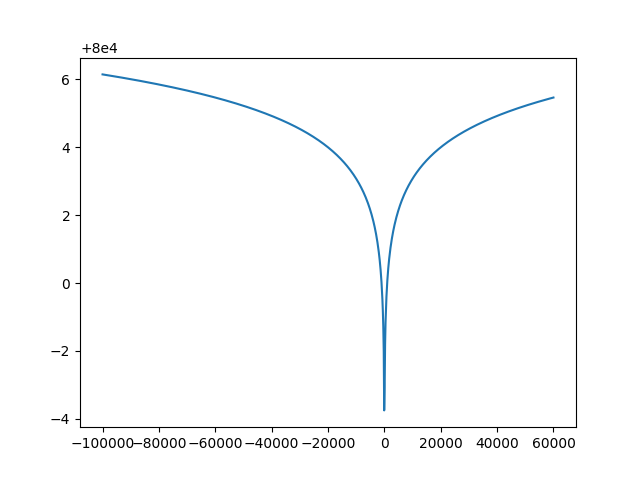

In [4]:
z_start = jnp.array(z_start, float)
z_end = jnp.array(z_end, float)

# phi_lambda, E_lambda = make_potential_and_efield_non_rel(phi_biprism, X, Y, Z)

phi_hat = phi_biprism + phi_0

# Get E field function. Notice there is no negative sign, as the way hawkes uses phi_hat, there is no minus before it (Equation 3.22).
dphi_hat_wires_electron_dx = phi_hat.diff(X)
dphi_hat_wires_electron_dy = phi_hat.diff(Y)
dphi_hat_wires_electron_dz = phi_hat.diff(Z)

phi_lambda = sp.lambdify([X, Y, Z], phi_hat, "jax")
E_lambda = sp.lambdify(
    [X, Y, Z],
    [
        dphi_hat_wires_electron_dx,
        dphi_hat_wires_electron_dy,
        dphi_hat_wires_electron_dz,
    ],
    "jax",
)

zs = jnp.linspace(z_start, z_end, 1000)

det_shape = (4096, 4096)
det_extent = (2e-5 * um, 2e-5 * um)
det_pixel_size = (det_extent[0] / det_shape[0], det_extent[1] / det_shape[1])

print(det_pixel_size)
plt.figure()
plt.plot(zs, phi_lambda(0, 0, zs), label="Potential")
PointSource = comp.InputPlane(z=z_start)
ElectrostaticLens = comp.ODE(
    z=z_start, z_end=z_end, phi_lambda=phi_lambda, E_lambda=E_lambda
)
Detector = comp.Detector(z=z_end, det_pixel_size=det_pixel_size, det_shape=det_shape)
model = [PointSource, ElectrostaticLens, Detector]

det_coords = Detector.get_coords()

[2048] [2048]


/nobackup/dl277493/.pyenv/versions/JaxGym/lib/python3.12/site-packages/ipympl/backend_nbagg.py:335: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.figure.savefig(buf, format='png', dpi='figure')


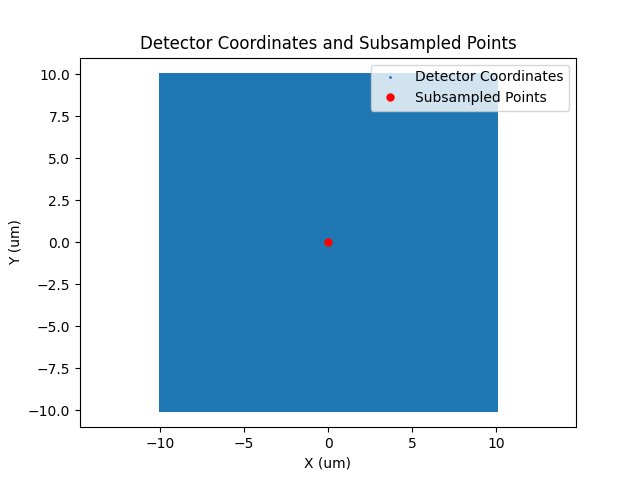

In [ ]:
x_det_shape, y_det_shape = Detector.det_shape

# Reshape det_coords into a 2D grid [rows, cols, 2]
det_coords_2d = det_coords.reshape(y_det_shape, x_det_shape, 2)

# Decide how many samples in X and Y
n_x = 1
n_y = 1
step_x = (x_det_shape - 1) // n_x
step_y = (y_det_shape - 1) // n_y

# Generate integer pixel‐indices evenly spaced over the detector grid
x_idxs = jnp.array(
    [2048]
)  # jnp.linspace(step_x // 2, (x_det_shape - 1), n_x).astype(int)
y_idxs = jnp.array(
    [2048]
)  # jnp.linspace(step_y // 2, (y_det_shape - 1), n_x).astype(int)
print(x_idxs, y_idxs)
# Build a mesh of those pixel indices
yy, xx = jnp.meshgrid(y_idxs, x_idxs, indexing="ij")

# Pick out the actual pixel coordinates
subset_det_coords = det_coords_2d[xx, yy].reshape(-1, 2)

# Plot the detector coordinates, and the sumsampled points
plt.figure()
plt.scatter(det_coords[:, 0], det_coords[:, 1], label="Detector Coordinates", s=1)
plt.plot(
    subset_det_coords[:, 0],
    subset_det_coords[:, 1],
    label="Subsampled Points",
    marker="o",
    markersize=5,
    linestyle="None",
    color="red",
)
plt.xlabel("X (um)")
plt.ylabel("Y (um)")
plt.title("Detector Coordinates and Subsampled Points")
plt.legend()
plt.axis("equal")
plt.show()

In [6]:
det_coords = Detector.get_coords()
pixel_width, pixel_height = Detector.det_pixel_size

# initialize some raw positive tilts and then make them negative
tilts = jax.random.uniform(
    jax.random.PRNGKey(1), shape=(subset_det_coords.shape[0], 2), minval=0, maxval=1e-4
)

cur_positions = jnp.zeros((tilts.shape[0], 2))
adam_solver = optax.adam(learning_rate=1e-7)
opt_state_fast = adam_solver.init(tilts)

history_fast = []
max_iters_fast = 8000
pbar = trange(max_iters_fast, desc="adam", leave=True)
for _ in pbar:
    tilts, opt_state_fast, loss_val = adam_step(
        tilts, opt_state_fast, subset_det_coords
    )

    history_fast.append(loss_val)
    pbar.set_postfix(loss=loss_val)
    if loss_val < 1e-14:
        break

results = {"History": history_fast}

adam:  28%|██▊       | 2267/8000 [00:46<01:57, 48.87it/s, loss=9.731141261180023e-15] 


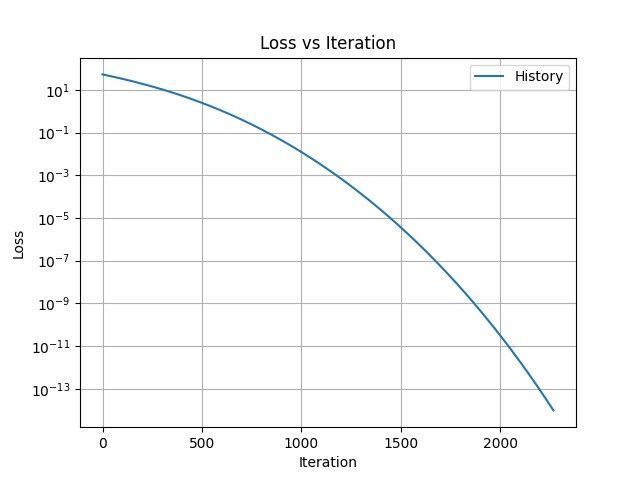

In [7]:
plt.figure()
for name, hist in results.items():
    plt.plot(hist, label=name)
plt.yscale("log")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Loss vs Iteration")
plt.legend()
plt.grid(True)
plt.show()

1


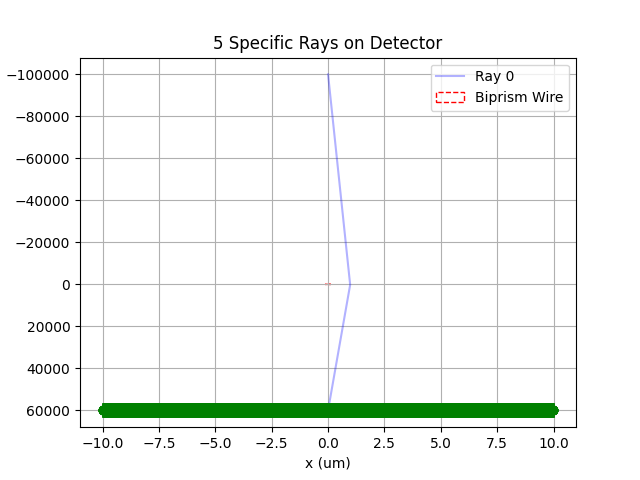

In [8]:
import diffrax
from jaxgym.ode import electron_equation_of_motion

z_start = jnp.array(PointSource.z, float)
z_end = jnp.array(Detector.z, float)
u0 = phi_lambda(0.0, 0.0, z_start)

# prepare batched initial states [x, y, dx, dy, pathlength]
n_rays = tilts.shape[0]
y0s = jnp.concatenate([cur_positions, tilts, jnp.zeros((n_rays, 1))], axis=1)

print(n_rays)

# ODE solver setup
term = diffrax.ODETerm(electron_equation_of_motion)
solver = diffrax.Dopri8()
stepsize_controller = diffrax.PIDController(
    rtol=1e-15, atol=1e-15, dtmax=1e4, dtmin=1e-15
)
adjoint = diffrax.ForwardMode()


def integrate_one(y0):
    sol_end = diffrax.diffeqsolve(
        term,
        solver,
        t0=z_start,
        t1=z_end,
        y0=y0,
        dt0=None,
        stepsize_controller=stepsize_controller,
        args=(phi_lambda, E_lambda, u0),
        adjoint=adjoint,
        saveat=diffrax.SaveAt(t0=True, t1=True, steps=True),
    )
    return sol_end.ys, sol_end.ts


ys, zs = jax.vmap(integrate_one)(y0s)

pixel_width, pixel_height = Detector.det_pixel_size

plt.figure()
# plot rays: now horizontal axis is position (x), vertical axis is z
for i in range(n_rays):
    mask = jnp.isfinite(zs[i])
    z_vals = zs[i][mask]
    x_vals = ys[i][mask, 0]
    plt.plot(x_vals, z_vals, color="blue", alpha=0.3, label="Ray %d" % i)

# plot detector points with horizontal error bars
for j in range(det_shape[0]):
    plt.errorbar(
        det_coords[j, 0],  # x‐coordinate
        Detector.z,  # y‐coordinate (z)
        xerr=pixel_width / 2,  # horizontal error
        fmt="o",
        color="g",
        capsize=5,
    )

# (optional) extract last finite point for ray 0
mask0 = jnp.isfinite(zs[0])
x0 = ys[0][mask0, 0]
z0 = zs[0][mask0]

# plot the circle of the biprism
ax = plt.gca()

circle = plt.Circle(
    (0, 0),  # center of the circle
    radius=r,
    color="red",
    fill=False,
    linestyle="--",
    label="Biprism Wire",
)
ax.add_artist(circle)

plt.xlabel("x (um)")
plt.ylabel("z (um)")
plt.title("5 Specific Rays on Detector")
plt.gca().invert_yaxis()  # flip the y-axis
plt.legend()
plt.grid(True)
plt.show()

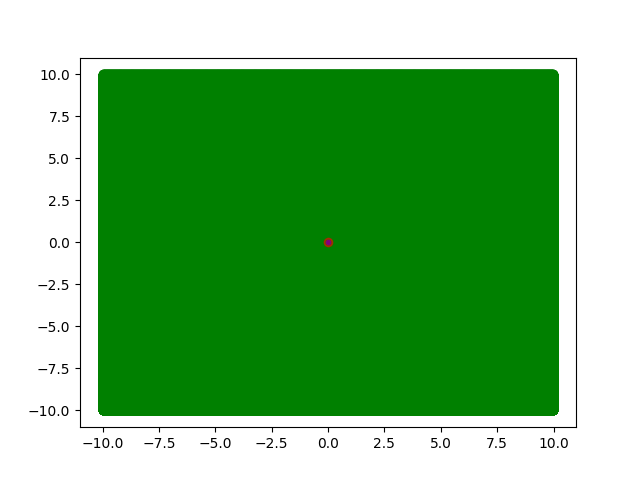

In [9]:
plt.figure()
plt.plot(
    det_coords[:, 0], det_coords[:, 1], "o", color="g", label="Detector", alpha=0.1
)
plt.plot(ys[:, 0, 0], ys[:, 0, 1], ".", color="b", label="Ray")
plt.plot(
    subset_det_coords[:, 0],
    subset_det_coords[:, 1],
    "o",
    color="r",
    label="Subsampled Points",
    alpha=0.5,
)

In [10]:
xs = jnp.zeros(n_rays)
ys = jnp.zeros(n_rays)
x_tilts = tilts[:, 0]
y_tilts = tilts[:, 1]
opls = jnp.zeros(n_rays)

rays = Ray(
    x=xs,
    y=ys,
    dx=x_tilts,
    dy=y_tilts,
    z=z_start,
    pathlength=opls,
    _one=jnp.ones(n_rays),
)

order = 4

positions = jnp.zeros((n_rays, 2))

tilts_x, tilts_y = tilts[:, 0], tilts[:, 1]
positions_x, positions_y = positions[:, 0], positions[:, 1]

calculate_derivatives_batched = jax.vmap(
    lambda ray: calculate_derivatives(ray, model, order)
)

batched_rays = Ray(
    x=positions_x,
    y=positions_y,
    dx=tilts_x,
    dy=tilts_y,
    z=jnp.ones(n_rays) * z_start,
    pathlength=opls,
    _one=jnp.ones(n_rays),
)

derivatives = calculate_derivatives_batched(batched_rays)

In [11]:
selected_vars = ["x", "y", "dx", "dy", "pathlength"]
multi_indices = order_indices(order, n_vars=len(selected_vars))

poly_dicts = poly_dict(derivatives, selected_vars, multi_indices)

In [12]:
print(poly_dicts[0].keys())

dict_keys(['x', 'y', 'dx', 'dy', 'pathlength'])


In [13]:
x_var, y_var, dx_var, dy_var, x_out, y_out, dx_out, dy_out, opl_var = sp.symbols(
    "x y x' y' x_out y_out dx_out, dy_out S", real=True
)
x_a, y_a = sp.symbols("x_a y_a", real=True)

polynomials = {}

for i in range(n_rays):
    polynomial = poly_dict_to_sympy_expr(
        poly_dicts[i], selected_vars, sym_vars=[x_var, y_var, dx_var, dy_var, opl_var]
    )
    polynomial["pathlength"] = polynomial["pathlength"].subs({opl_var: 0})
    polynomials[i] = polynomial

/tmp/ipykernel_2200924/3728503624.py:17: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


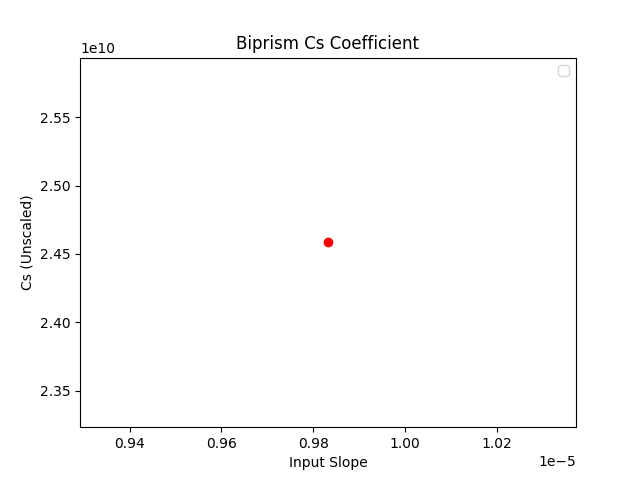

In [14]:
# plot the constant (i.e. evaluate at zero) term of each pathlength‐polynomial
plt.figure()

coeffs = []
for i in range(n_rays):
    expr = polynomials[i]["pathlength"]
    # extract the coefficient of (x')**4
    coeff = expr.coeff(dx_var, 4)
    coeffs.append(coeff)

plt.plot(jnp.abs(tilts[:, 0]), coeffs, "-", color="k")
plt.plot(jnp.abs(tilts[:, 0]), coeffs, "o", color="r")

plt.xlabel("Input Slope")
plt.ylabel("Cs (Unscaled)")
plt.title("Biprism Cs Coefficient")
plt.legend()
plt.show()

In [15]:
polynomials["x"] = sp.simplify(polynomials[0]["x"])
polynomials["y"] = sp.simplify(polynomials[0]["y"])
polynomials["dx"] = sp.simplify(polynomials[0]["dx"])
polynomials["dy"] = sp.simplify(polynomials[0]["dy"])
polynomials["pathlength"] = sp.simplify(polynomials[0]["pathlength"])

jax_poly_x = sp.lambdify(
    [x_var, y_var, dx_var, dy_var], polynomials["x"], modules="jax"
)
jax_poly_y = sp.lambdify(
    [x_var, y_var, dx_var, dy_var], polynomials["y"], modules="jax"
)
jax_poly_dx = sp.lambdify(
    [x_var, y_var, dx_var, dy_var], polynomials["dx"], modules="jax"
)
jax_poly_dy = sp.lambdify(
    [x_var, y_var, dx_var, dy_var], polynomials["dy"], modules="jax"
)
jax_poly_opl = sp.lambdify(
    [x_var, y_var, dx_var, dy_var], polynomials["pathlength"], modules="jax"
)

## Create amplitude evaluation function ##
dSdxodxp = sp.diff(polynomials["pathlength"], x_var, dx_var)
dSdxodyp = sp.diff(polynomials["pathlength"], x_var, dy_var)
dSdyodxp = sp.diff(polynomials["pathlength"], y_var, dx_var)
dSdyodyp = sp.diff(polynomials["pathlength"], y_var, dy_var)
jacobian = sp.Matrix([[dSdxodxp]])
print(jacobian)

Matrix([[0.000212088323473807*x**2 + 47.9456163661764*x*x' - 2.85364501897472e-15*x*y' - 0.000163027997268619*x + 2673678.40404843*x'**2 - 2.87009524091272e-10*x'*y' - 19.0193640422223*x' + 0.000430235109011634*y'**2 + 9.83103125418237e-5]])


In [16]:
display(sp.diff(polynomials["pathlength"], dx_var))

7.06961078246025e-5*x**3 + 23.9728081830882*x**2*x' - 1.42682250948736e-15*x**2*y' - 8.15139986343096e-5*x**2 + 2673678.40404843*x*x'**2 - 2.87009524091272e-10*x*x'*y' - 19.0193640422223*x*x' + 0.000430235109011634*x*y'**2 + 9.83103125418237e-5*x + 98335786389.5539*x'**3 - 1.44327312616067e-5*x'**2*y' - 1086805.07039803*x'**2 - 79950.5282018874*x'*y'**2 - 9.69706623594024e-8*x'*y' + 160012.728606146*x' + 2.38043167654446e-12*y'**3 + 0.784092552837791*y'**2 + 9.51012781397084e-13*y' + 2.62103986305573

In [17]:
amplitude = sp.lambdify(
    [x_var, y_var, dx_var, dy_var],
    1 / (1j * wavelength * sp.sqrt(jacobian.det())),
    modules="jax",
)

In [18]:
from functools import partial


@partial(jax.jit, static_argnames=["num_x", "num_y"])
def simpson2d(f, ax, bx, ay, by, num_x, num_y):
    """
    Evaluate a 2D integral using Simpson's rule for potentially different
    numbers of points in the x and y dimensions.

    Parameters:
      f (ndarray): 1D array of ravelled 2D function values.
      ax, bx (float): Integration bounds for x.
      ay, by (float): Integration bounds for y.
      num_x (int): Number of points in x dimension.
      num_y (int): Number of points in y dimension.

    Returns:
      float: Approximate value of the integral.
    """
    hx = (bx - ax) / (num_x - 1)
    hy = (by - ay) / (num_y - 1)

    idx_x = jax.lax.iota(jnp.int32, num_x)
    wx = 4 - 2 * (idx_x % 2)
    wx = wx.at[0].set(1)
    wx = wx.at[-1].set(1)

    idx_y = jax.lax.iota(jnp.int32, num_y)
    wy = 4 - 2 * (idx_y % 2)
    wy = wy.at[0].set(1)
    wy = wy.at[-1].set(1)

    # Construct the 2D weight matrix as an outer product.
    weights = jnp.outer(wx, wy).ravel()

    # Multiply by hx*hy/9 based on Simpson's rule in two dimensions.
    return hx * hy / 9 * jnp.sum(f * weights)

In [19]:
import optimistix as optx
import tqdm

object_x = jnp.linspace(0, 0, 1)
object_y = jnp.linspace(0, 0, 1)
object_x, object_y = jnp.meshgrid(object_x, object_y)
object_x = object_x.ravel()
object_y = object_y.ravel()

x_det_shape, y_det_shape = Detector.det_shape

# flatten detector coordinates
x_det = det_coords[:, 0].ravel()
y_det = det_coords[:, 1].ravel()


@jax.jit
def solve_slopes(x_input, y_input, x_det_pixel, y_det_pixel):
    # Find the slope of the ray in the input plane that will land on the desired detector pixel
    def input_slope_from_image_position_loss(params, args):
        dx, dy = params
        x_in, y_in, x_out, y_out = args
        res_x = jax_poly_x(x_in, y_in, dx, dy) - x_out
        res_y = jax_poly_y(x_in, y_in, dx, dy) - y_out

        return res_x, res_y

    slope_in_x, slope_in_y = optx.root_find(
        input_slope_from_image_position_loss,
        optx.Newton(rtol=1e-14, atol=1e-14),
        jnp.array([0.0, 0.0]),  # initial guess for slopes
        (x_input, y_input, x_det_pixel, y_det_pixel),
    ).value

    return slope_in_x, slope_in_y


solve_slopes_vmap = jax.vmap(solve_slopes, in_axes=(None, None, 0, 0))


def compute_wave(x_input, y_input):
    dx_input, dy_input = solve_slopes_vmap(x_input, y_input, x_det, y_det)
    opl = jax_poly_opl(x_input, y_input, dx_input, dy_input)

    phase = (2 * jnp.pi * (opl / wavelength) + jnp.pi) % (2 * jnp.pi) - jnp.pi
    amp = amplitude(x_input, y_input, dx_input, dy_input)

    kernel = jnp.exp(1j * phase) * amp
    return kernel


dx = Detector.det_pixel_size[0]
dy = Detector.det_pixel_size[1]


def compute_integral(U, x_input, y_input):
    wave_detector = compute_wave(x_input, y_input)
    out = wave_detector * U * dx * dy

    return out


Uobject = 1.0 + 0.0j

compute_integral_batch = compute_integral

batch_size = 1  # number of pixels per batch
output = jnp.zeros(len(x_det), dtype=jnp.complex128)

U_batch = 1.0
x_batch = 0.0
y_batch = 0.0

det_wave_batch = compute_integral_batch(
    U_batch,  # Input Object Wavefunction
    x_batch,  # Object x-coordinates
    y_batch,  # Object y-coordinates
)
output = det_wave_batch

output = output.reshape((x_det_shape, y_det_shape))

In [20]:
# Copy the phase and amplitude profiles, and flip along the x-axis
det_wave = jnp.copy(output)
det_wave = jnp.fliplr(det_wave)

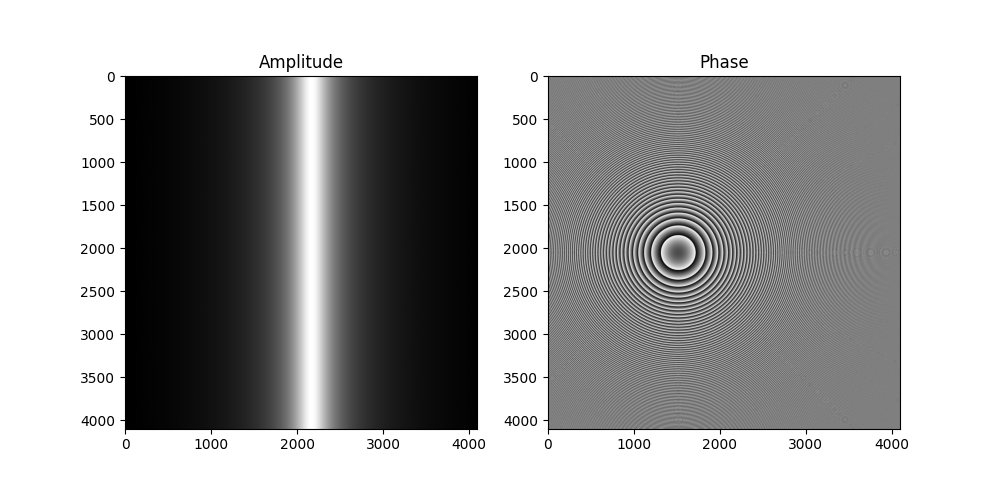

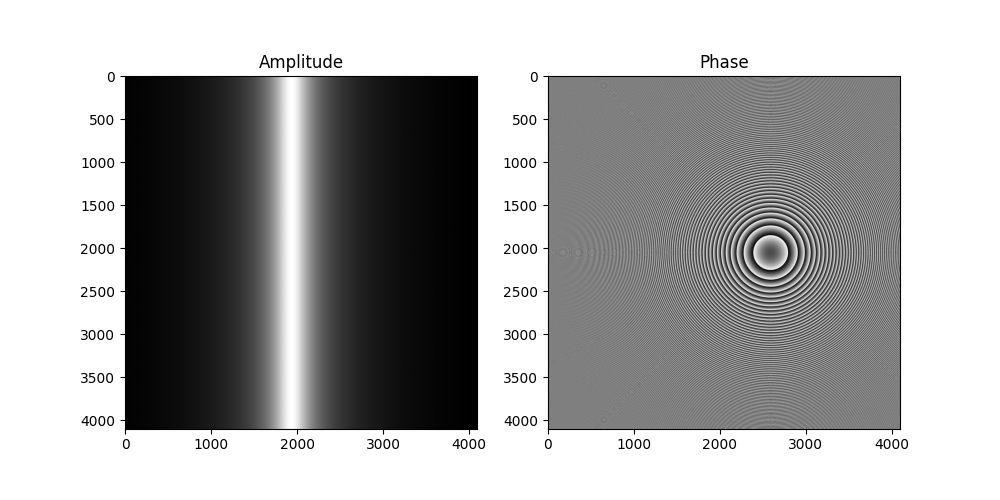

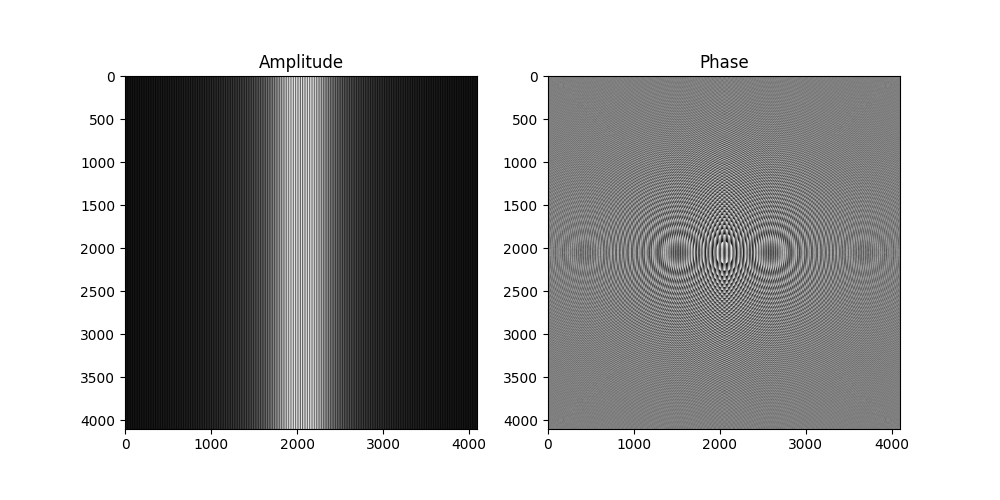

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(jnp.abs(output), cmap="gray")
ax[0].set_title("Amplitude")
ax[1].imshow(jnp.angle(output), cmap="gray")
ax[1].set_title("Phase")
plt.show()

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(jnp.abs(det_wave), cmap="gray")
ax[0].set_title("Amplitude")
ax[1].imshow(jnp.angle(det_wave), cmap="gray")
ax[1].set_title("Phase")
plt.show()

interfered_wave = det_wave + output

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(jnp.abs(interfered_wave), cmap="gray")
ax[0].set_title("Amplitude")
ax[1].imshow(jnp.angle(interfered_wave), cmap="gray")
ax[1].set_title("Phase")
plt.show()

Text(0.5, 1.0, 'Phase')

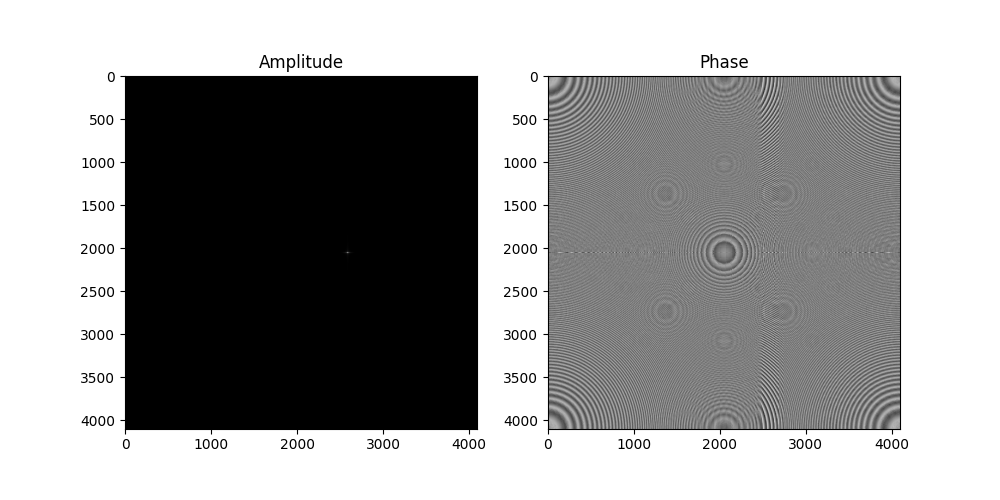

In [22]:
# Angular spectrum propagation 16 cm backwards
z_prop = -0.16 * um  # propagation distance in meters (negative = backwards)
lam = wavelength  # wavelength in meters
nx, ny = det_wave.shape
dx, dy = Detector.det_pixel_size  # pixel size in meters

# build frequency coordinates
fx = jnp.fft.fftfreq(nx, dx)
fy = jnp.fft.fftfreq(ny, dy)
FX, FY = jnp.meshgrid(fx, fy, indexing="ij")

# transfer function for angular spectrum
H = jnp.exp(
    1j * 2 * jnp.pi * z_prop * jnp.sqrt(jnp.clip(1 / lam**2 - FX**2 - FY**2, 0.0))
)

# forward FFT, apply H, and inverse FFT
A = jnp.fft.fft2(det_wave)
AS = A * H
fft_wave = jnp.fft.ifft2(AS)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(jnp.abs(fft_wave), cmap="gray")
ax[0].set_title("Amplitude")
ax[1].imshow(jnp.angle(fft_wave), cmap="gray")
ax[1].set_title("Phase")

In [23]:
# forward FFT, apply H, and inverse FFT
A = jnp.fft.fftshift(jnp.fft.fft2(det_wave))
AS = A * H
fft_wave = jnp.fft.ifft2(jnp.fft.ifftshift(AS))